In [1]:
import numpy as np

from server.layers.detector import DetectionLayer
from server.layers.header_reader import HeaderReader
from server.layers.gps_translator import GPSTranslationLayer
from server.layers.parallel import ParallelLayer

def pipeline(model_path: str, backend: str):
    parallel = ParallelLayer([
        HeaderReader(),
        DetectionLayer(model_path, engine='auto'),
    ], use_threads=True)

    gps_translation = GPSTranslationLayer()

    def run_pipeline(path: str):
        try:
            header, bboxes = parallel.run((path,), share_input=True)

            if len(bboxes) == 0:
                return np.empty((0, 2))

            output = gps_translation.run(header, bboxes, backend=backend)

            bbox_list = np.array([
                (float(bbox[0]), float(bbox[1]))
                for bbox in output
            ])
        except:
            return np.empty((0, 2))

        return bbox_list

    return run_pipeline

In [2]:
import os
from pathlib import Path
project_path = Path(os.path.abspath(''))

model_path = str(project_path / 'yolo' / 'yolov3-aerial-int8_2.tflite')
# model_path = str(project_path / 'yolo' / 'yolov3-aerial.onnx')

backends = ['geopy', 'gdal']
pipes = [pipeline(model_path, backend) for backend in backends]


images_folder = Path(project_path / "data_ignore" / "sequential_with_exif")
images = [images_folder / img for img in os.listdir(str(images_folder)) if img.lower().endswith(".jpg")]
images.sort(key=lambda x: int(str(x)[-8:-4]))  # hack to sort by image number

In [3]:
from geopy.distance import geodesic

distances = []

for img in images:
    print(str(img))
    ys0 = pipes[0](str(img))
    ys1 = pipes[1](str(img))

    assert len(ys0) == len(ys1)

    for y0, y1 in zip(ys0, ys1):
        distances.append(geodesic(y0, y1).meters)

distances = np.array(distances)

/home/allanlago/Documents/jupyter-notebooks/rt-flight/data_ignore/sequential_with_exif/DJI_0001.JPG
/home/allanlago/Documents/jupyter-notebooks/rt-flight/data_ignore/sequential_with_exif/DJI_0002.JPG
/home/allanlago/Documents/jupyter-notebooks/rt-flight/data_ignore/sequential_with_exif/DJI_0003.JPG
/home/allanlago/Documents/jupyter-notebooks/rt-flight/data_ignore/sequential_with_exif/DJI_0004.JPG
/home/allanlago/Documents/jupyter-notebooks/rt-flight/data_ignore/sequential_with_exif/DJI_0005.JPG


ERROR:root:Errors occurred while running parallel layers: [None, OSError('image file is truncated (0 bytes not processed)')]
ERROR:root:Errors occurred while running parallel layers: [None, OSError('image file is truncated (0 bytes not processed)')]


/home/allanlago/Documents/jupyter-notebooks/rt-flight/data_ignore/sequential_with_exif/DJI_0006.JPG
/home/allanlago/Documents/jupyter-notebooks/rt-flight/data_ignore/sequential_with_exif/DJI_0007.JPG
/home/allanlago/Documents/jupyter-notebooks/rt-flight/data_ignore/sequential_with_exif/DJI_0008.JPG
/home/allanlago/Documents/jupyter-notebooks/rt-flight/data_ignore/sequential_with_exif/DJI_0009.JPG
/home/allanlago/Documents/jupyter-notebooks/rt-flight/data_ignore/sequential_with_exif/DJI_0010.JPG
/home/allanlago/Documents/jupyter-notebooks/rt-flight/data_ignore/sequential_with_exif/DJI_0011.JPG
/home/allanlago/Documents/jupyter-notebooks/rt-flight/data_ignore/sequential_with_exif/DJI_0012.JPG
/home/allanlago/Documents/jupyter-notebooks/rt-flight/data_ignore/sequential_with_exif/DJI_0013.JPG
/home/allanlago/Documents/jupyter-notebooks/rt-flight/data_ignore/sequential_with_exif/DJI_0014.JPG
/home/allanlago/Documents/jupyter-notebooks/rt-flight/data_ignore/sequential_with_exif/DJI_0015.JPG


In [5]:
distances.mean(), distances.std()

(0.26466245176448894, 0.1577044411946219)

In [9]:
distances.max()

0.5790621188297994

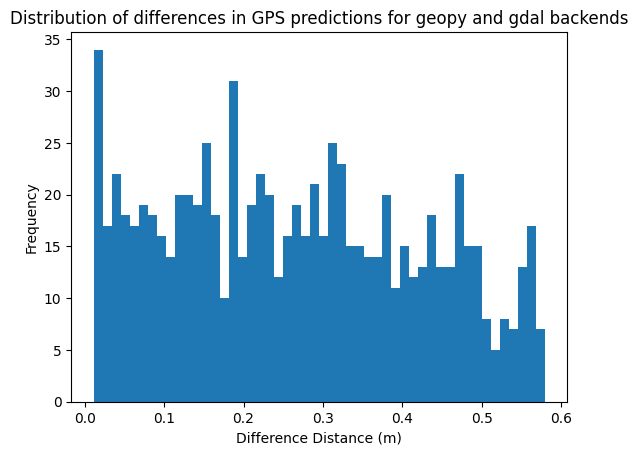

In [15]:
import matplotlib.pyplot as plt

counts, bins = np.histogram(distances, bins=50)
plt.hist(bins[:-1], bins, weights=counts)
plt.title('Distribution of differences in GPS predictions for geopy and gdal backends')
plt.xlabel('Difference Distance (m)')
plt.ylabel('Frequency');